# MLP Comparison Doc
------------------------------------------------------


Goal: setup a test bench to train and test MLP with different data and params

### Imports:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Datasets:

In [2]:
from torchvision import datasets, transforms

img_res = (28, 28)  # SET RESOLUTION


resize_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                transforms.Resize(img_res)
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=resize_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=resize_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0


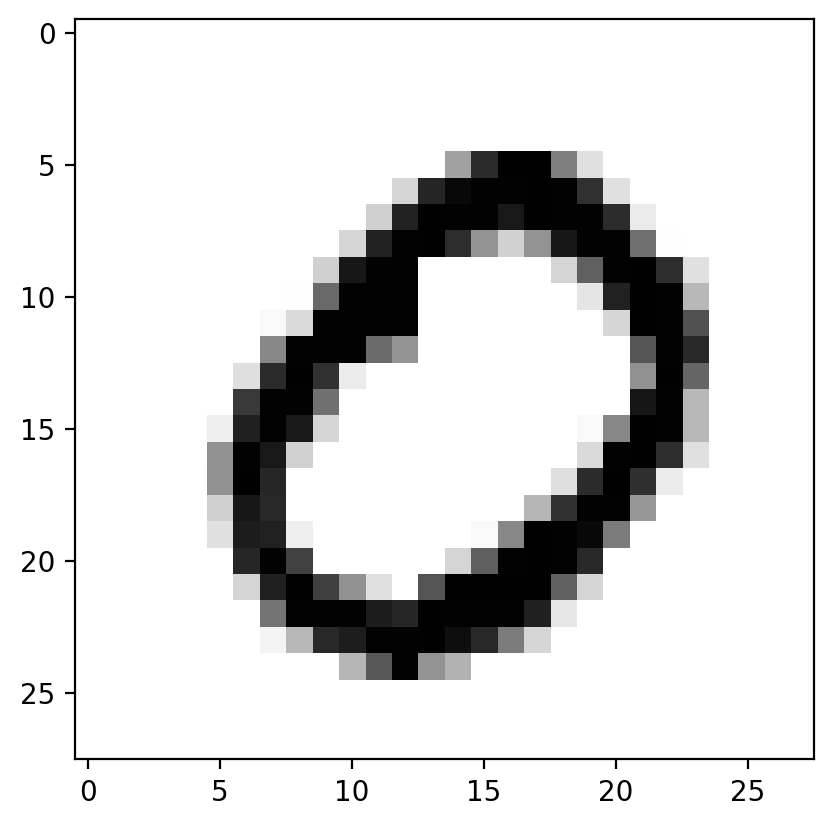

In [3]:
### Check images

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)
plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())

### MLP:

In [44]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001,dropout=0.1): # nlabels = 10 for digit classification
        super().__init__()

        # MODEL ARCHITECTURE:
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=dropout)

        # Other params
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.test_loss_during_training = []

    ### INFERENCE ###
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.dropout(x)
        x = self.logsoftmax(x) # logsoftmax: probabilities for each of the ten outputs
        return x

    def forward_preActivation(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.dropout(x) # DON'T APPLY SOFTMAX
        return x


    ### TRAINING ###
    def train(self,trainloader):
    
            # Optimization Loop
            for e in range(int(self.epochs)):
    
                # Random data permutation at each epoch
                running_loss = 0.
                testing_loss = 0.

                # TRAINING LOSS
                for images, labels in trainloader:             
    
                    self.optim.zero_grad()  #TO RESET GRADIENTS!
    
                    out = self.forward(images.view(images.shape[0], -1))
    
                    # Compute loss
                    loss = self.criterion(out,labels)
    
                    running_loss += loss.item()
    
                    # Compute gradients (back propagation)
                    loss.backward()
    
                    # Update weights
                    self.optim.step()

                # TESTING LOSS
                with torch.no_grad():
                    for images, labels in testloader:             
        
                        out = self.forward(images.view(images.shape[0], -1))
        
                        # Compute loss
                        loss = self.criterion(out,labels)
        
                        testing_loss += loss.item()

                self.loss_during_training.append(running_loss/len(trainloader))
                self.test_loss_during_training.append(testing_loss/len(testloader))
    
                if(e % 1 == 0): # Every 10 epochs
    
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    ### COMPUTE ACCURACY ###
    def eval_performance(self,dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

### Training:

Training loss after 0 epochs: 0.459010
Training loss after 1 epochs: 0.237740
Training loss after 2 epochs: 0.188618
Training loss after 3 epochs: 0.156320
Training loss after 4 epochs: 0.131532
Training loss after 5 epochs: 0.119730
Training loss after 6 epochs: 0.106547
Training loss after 7 epochs: 0.097264
Training loss after 8 epochs: 0.088867
Training loss after 9 epochs: 0.084623
Training loss after 10 epochs: 0.079879
Training loss after 11 epochs: 0.074475
Training loss after 12 epochs: 0.071141
Training loss after 13 epochs: 0.065338
Training loss after 14 epochs: 0.063363
Training loss after 15 epochs: 0.057806
Training loss after 16 epochs: 0.057106
Training loss after 17 epochs: 0.052874
Training loss after 18 epochs: 0.051695
Training loss after 19 epochs: 0.049643
Train Accuracy 0.985708
Test Accuracy 0.970044


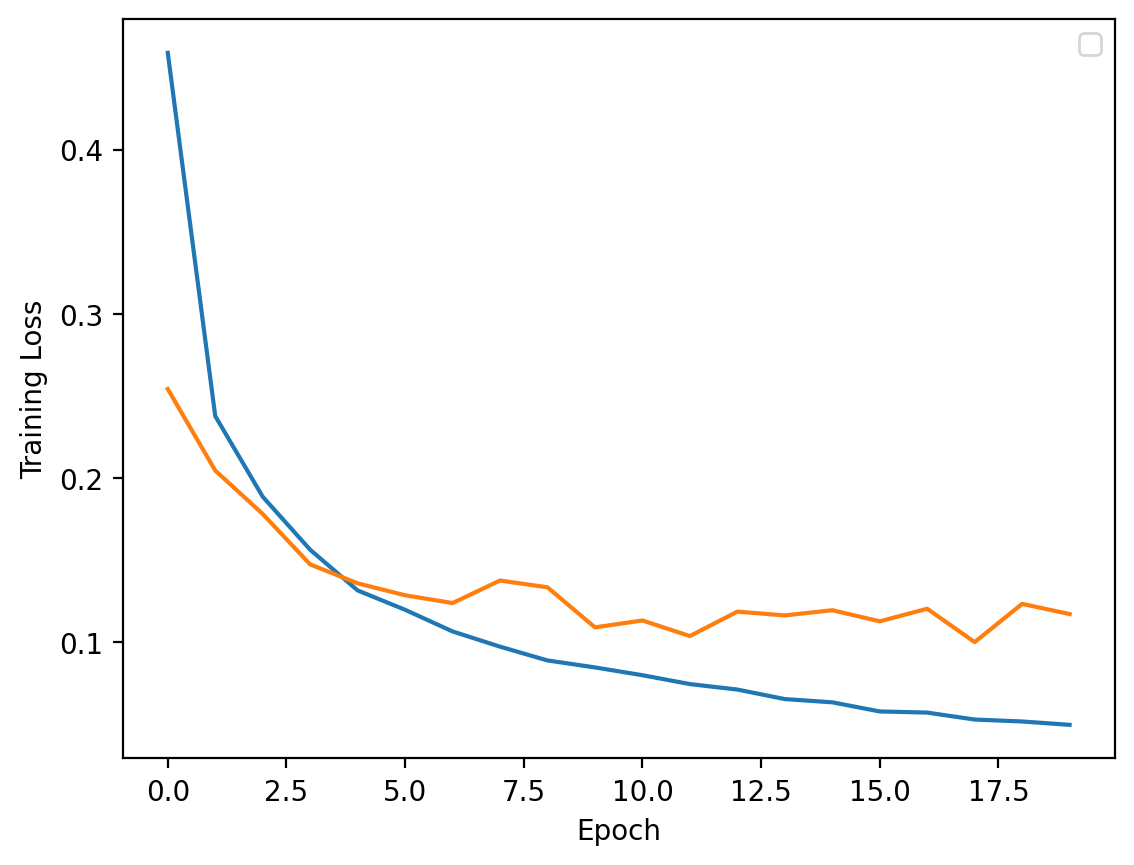

In [45]:
my_MLP = MLP(dimx=img_res[0]*img_res[1],hidden1=64,hidden2=32,nlabels=10,epochs=20,lr=1e-3,dropout=0)

my_MLP.train(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Testing Loss"])
plt.plot(my_MLP.loss_during_training)
fig = plt.plot(my_MLP.test_loss_during_training)

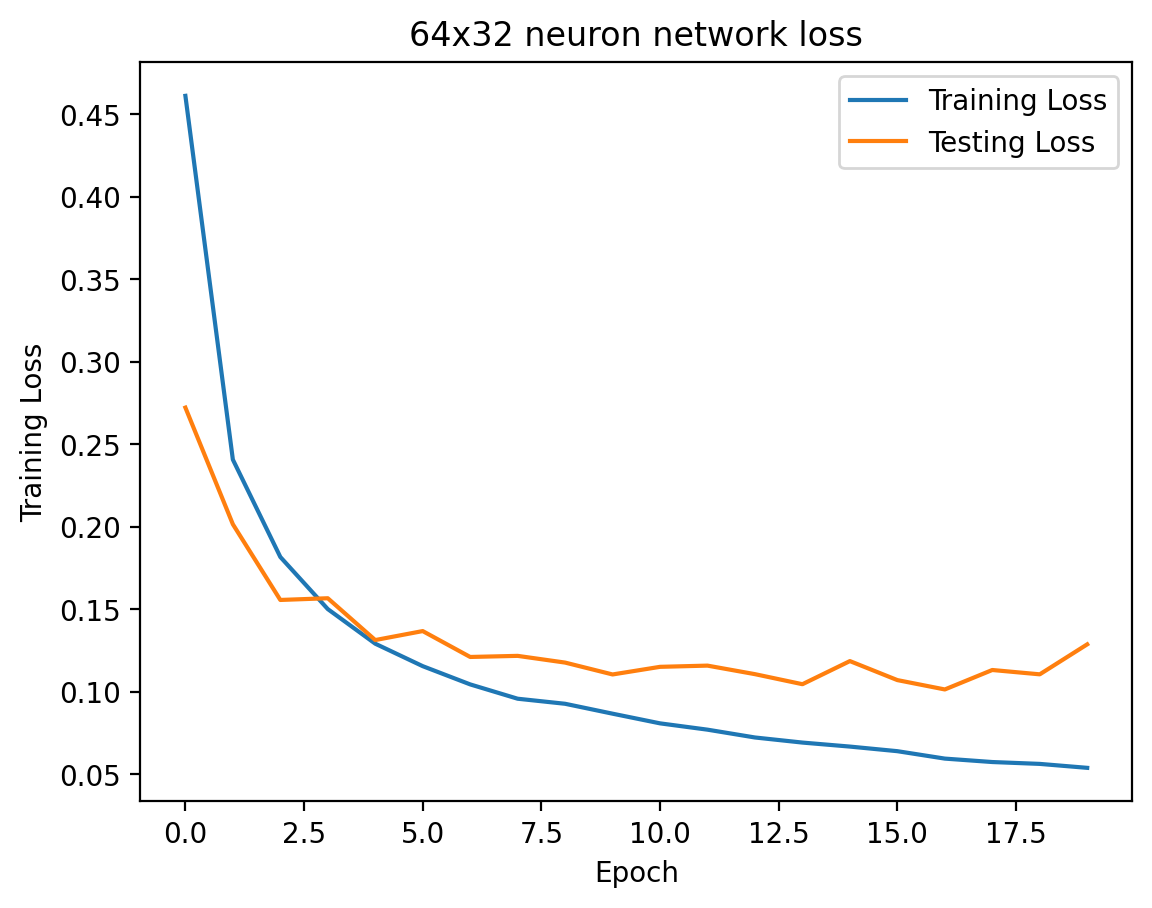

In [6]:
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.plot(my_MLP.loss_during_training)
plt.plot(my_MLP.test_loss_during_training)
plt.title("64x32 neuron network loss")
fig = plt.legend(["Training Loss", "Testing Loss"])

### Visualize the model:

### Activation Function Exploration

In [82]:
# Recreating the pytorch softmax function
# Scales down the exponents by the maximum input to prevent algorithmic overflow
def torch_softmax(x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.exp(x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs 

# Modify: we can adjust the base of the exponent from e
# Scales down the exponents by the maximum input to prevent algorithmic overflow
def custom_softmax_scaled(base, x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.pow(base, x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs

# Modify: we can adjust the base of the exponent from e
# No scaling
def custom_softmax(base, x):
    x_exp = torch.pow(base, x)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs

In [89]:
m1 = nn.LogSoftmax(dim=1)
m2 = nn.Softmax(dim=1)
input = torch.randn(2, 3)
print("INPUT:")
print(input)
output1 = m1(input)
output2 = m2(input)
output3 = torch_softmax(input)
output4 = custom_softmax_scaled(2, input)
output5 = custom_softmax(2, input)
print("OUTPUT torch.exp(nn.LogSoftmax(dim=1)):")
print(torch.exp(output1))
print("OUTPUT nn.Softmax(dim=1):")
print(output2)
print("OUTPUT torch_softmax():")
print(output3)
print("OUTPUT custom_softmax_scaled(base=2):")
print(output4)
print("OUTPUT custom_softmax(base=2):")
print(output5)

INPUT:
tensor([[ 1.0983,  0.2267,  0.1991],
        [ 0.6197, -1.2169,  0.3530]])
OUTPUT torch.exp(nn.LogSoftmax(dim=1)):
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT nn.Softmax(dim=1):
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT torch_softmax():
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT custom_softmax_scaled(base=2):
tensor([[0.4801, 0.2624, 0.2574],
        [0.4737, 0.1326, 0.3937]])
OUTPUT custom_softmax(base=2):
tensor([[0.4801, 0.2624, 0.2574],
        [0.4737, 0.1326, 0.3937]])


### Testing on imported images:

Draw white on a black background: http://pixilart.com/draw/28x28-517d2f9c7af2f70#

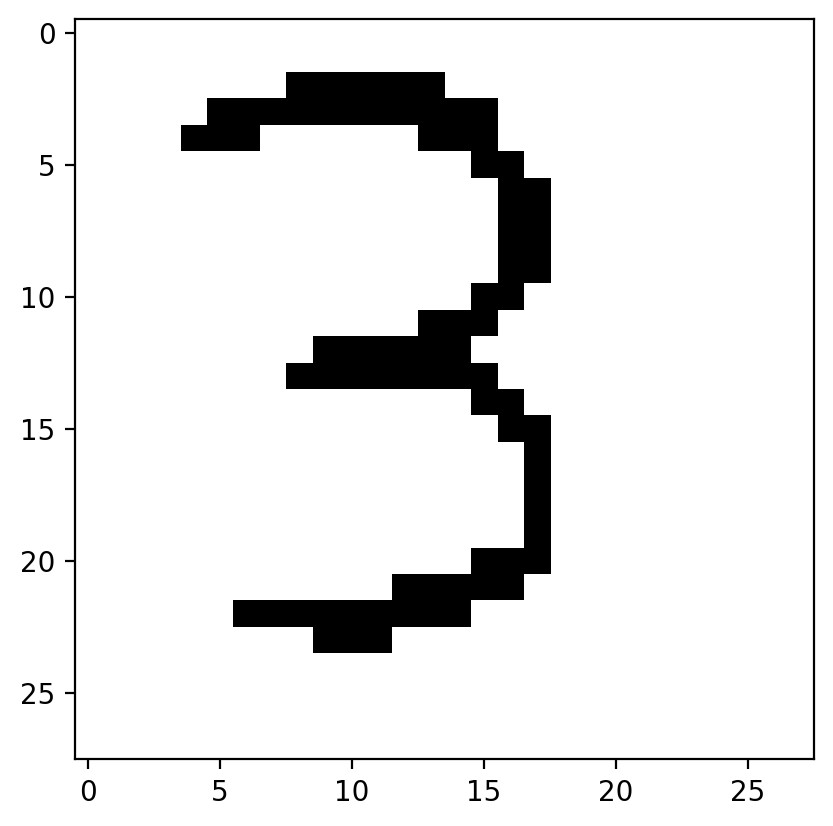

In [69]:
from PIL import Image

# Open the image
img = Image.open("drewDigits/drew3_1.png").convert('F')

# Convert to numpy array
import numpy as np
img_array = np.array(img)/260
fig = plt.imshow(img_array, cmap='binary')

tensor([[-17.6189,   1.6513,  -7.2265,  12.9845, -11.9336,   0.8680, -21.0795,
          -8.0127,  -4.7578,  -5.4536]])
tensor([[5.1179e-14, 1.1968e-05, 1.6691e-09, 9.9998e-01, 1.5072e-11, 5.4686e-06,
         1.6077e-15, 7.6036e-10, 1.9706e-08, 9.8275e-09]])
tensor(1.0000)


<BarContainer object of 10 artists>

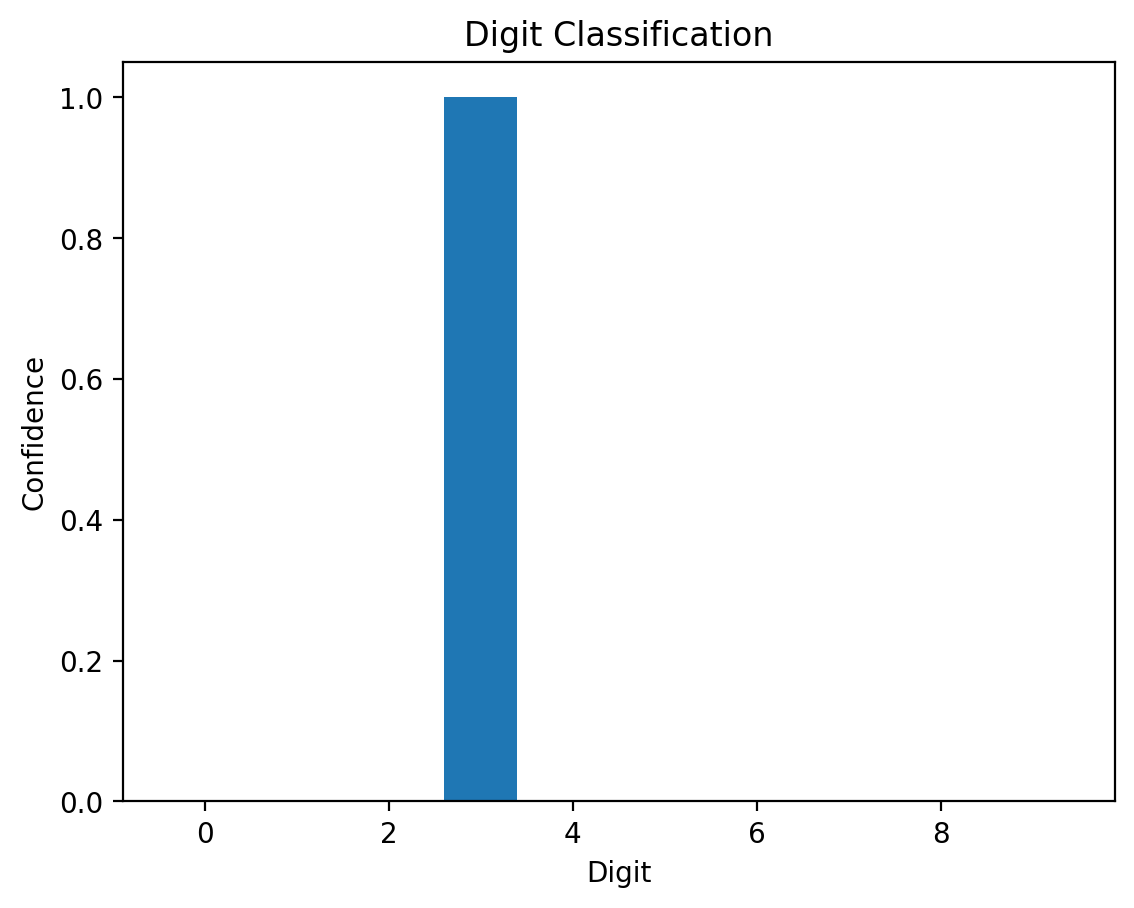

In [77]:
### Run the model
img_array = img_array.reshape([1, 784])
img_array = np.where(img_array == 0, -1, img_array)

with torch.no_grad():
    #logprobs = my_MLP.forward(torch.from_numpy(img_array))
    
    logits = my_MLP.forward_preActivation(torch.from_numpy(img_array))
    print(logits)

#probs = np.exp(logprobs)
probs = torch_softmax(logits)
print(probs)
#probs = custom_softmax_scaled(2, logits)

print(torch.sum(probs))
top_p, top_class = logprobs.topk(1, dim=1)

plt.xlabel("Digit")
plt.ylabel("Confidence")
plt.title("Digit Classification")
plt.bar(labels.unique(), probs[0])

### Visualize the model:

In [10]:
from torchviz import make_dot

# Generate the dot graph
dot = make_dot(my_MLP(torch.from_numpy(img_array)), params=dict(my_MLP.named_parameters()))

# Save the graph as a PDF
dot.render("model_visualization", format="pdf") 

'model_visualization.pdf'

3


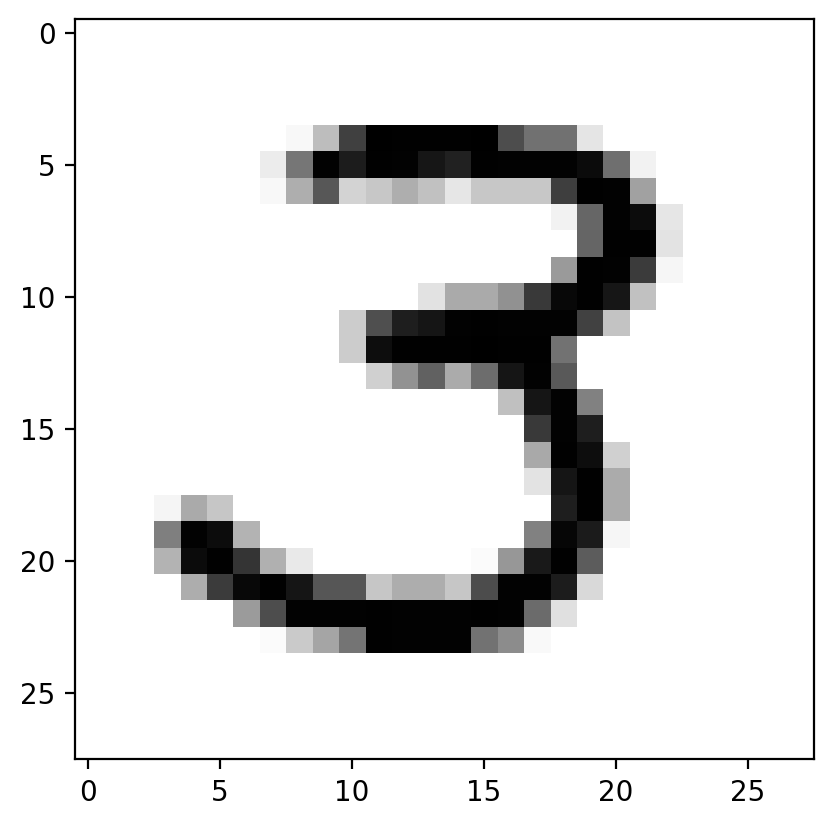

In [95]:
### FOR TESTING: how do the images in trainloader look to the model?

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)

logprobs = my_MLP.forward(images.view(images.shape[0], -1))
top_p, top_class = logprobs.topk(1, dim=1)

plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())